
# <span style="color:DarkSeaGreen">JumpStart Lab 2</span>

This lab does the following:

- Uses the endpoint created in Lab 1
- Implements SageMaker application-autoscaling
- Tests the functionality 



# <span style="color:DarkSeaGreen">Prepare Your Environment</span>
### Note if you want a venv, see Lab 1

# Lab 2 Starts Here!

# <span style="color:DarkSeaGreen">Setup</span>

In [1]:
# region
# for the purpose of this lab, us-east-1, us-west-2, eu-west-1 has the broadest coverage of JumpStart models and instance types
# if you provision in other regions, you may not have access to all the models or instance types, and may need to request increase of quotas for some instance types
myRegion='us-east-1'

# parameter store
myParameterStoreChosenModel='doit-jumpstart-sagemaker-chosen-model'
myParameterStoreEndpointName='doit-jumpstart-sagemaker-endpoint-name'
myParameterStoreIAMARN='doit-jumpstart-sagemaker-iam-arn'

# application auto scaling policy
myEndpointScalingPolicyName='doit-jumpstart-sagemaker-endpoint-scaling-policy'

print ('Done! Move to the next cell ->')

Done! Move to the next cell ->


In [2]:
# import libraries
import boto3
from certifi import where

botoSession = boto3.Session(region_name=myRegion)

# Configure boto3 to use certifi's certificates - helps avoid SSL errors if your system’s certificate store is out of date or missing root certs
sts_client = boto3.client('sts', verify=where())
myAccountNumber = sts_client.get_caller_identity()["Account"]
print(myAccountNumber)
print(sts_client.get_caller_identity()["Arn"])

# create clients we can use later
# iam
iam = boto3.client('iam', region_name=myRegion, verify=where())
# ssm
ssm = boto3.client('ssm', region_name=myRegion, verify=where())

print ('Done! Move to the next cell ->')

546709318047
arn:aws:iam::546709318047:user/simon-davies-cli
Done! Move to the next cell ->


In [3]:
# define tags added to all services we create
myTags = [
    {"Key": "env", "Value": "non_prod"},
    {"Key": "owner", "Value": "doit-jumpstart"},
    {"Key": "project", "Value": "lab1"},
    {"Key": "author", "Value": "simon"},
]
myTagsDct = {
    "env": "non_prod",
    "owner": "doit-jumpstart",
    "project": "lab1",
    "author": "simon",
}

print ('Done! Move to the next cell ->')

Done! Move to the next cell ->


# <span style="color:DarkSeaGreen">IAM</span>

In [4]:
def getSageMakerExecutionRole():
    """
    Gets a role required for SageMaker to run jobs on your behalf
    Only needed if this is being run in a local IDE, not needed if in SageMaker Studio or SageMaker Notebook Instance

    Args:
        None

    Returns:
        An IAM execution role ARN
    """

    # get the role we created in the previous lab from the parameter store
    response = ssm.get_parameter(Name=myParameterStoreIAMARN)
    myRoleSageMakerExecutionARN = response['Parameter']['Value']
    print(f"Retrieved role from parameter store: {myRoleSageMakerExecutionARN}")    

    return myRoleSageMakerExecutionARN

# <span style="color:DarkSeaGreen">Get Execution Role and Session</span>
- SageMaker requires an execution role to assume on your behalf

In [5]:
from sagemaker.session import get_execution_role
from sagemaker.session import Session

try:
    # if this is being run in a SageMaker AI JupyterLab Notebook
    myRoleSageMakerExecutionARN = get_execution_role()
except:
    # if this is being run in a local IDE - we need to create our own role
    myRoleSageMakerExecutionARN = getSageMakerExecutionRole()

# make sure we get a session in the correct region (needed as it can use the aws configure region if running this locally
sageMakerSession = Session(boto_session=botoSession)

print(myRoleSageMakerExecutionARN)
print(sageMakerSession)

print ('Done! Move to the next cell ->')

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/simondavies/Library/Application Support/sagemaker/config.yaml


Couldn't call 'get_role' to get Role ARN from role name simon-davies-cli to get Role path.


Retrieved role from parameter store: arn:aws:iam::546709318047:role/doit-jumpstart-sagemaker-execution-role
arn:aws:iam::546709318047:role/doit-jumpstart-sagemaker-execution-role
Done! Move to the next cell ->


# <span style="color:DarkSeaGreen">Get the Endpoint from Lab 1</span>

In [6]:
# get the endpoint created in lab1
from sagemaker.predictor import Predictor
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

# get the endpoint name from parameter store
response = ssm.get_parameter(
    Name=myParameterStoreEndpointName
)
endpointName = response['Parameter']['Value']
print(f"Using endpoint name: {endpointName}")  

# create a predictor to interact with the endpoint - need to specify the default serializer and deserializer this time
predictor = Predictor(
    endpoint_name=endpointName,
    sagemaker_session=sageMakerSession,
    serializer=JSONSerializer(),      
    deserializer=JSONDeserializer()
)

print ('Done! Move to the next cell ->')

Using endpoint name: stabilityai-stable-diffusion-xl-base-1--2025-09-26-07-12-04-199
Done! Move to the next cell ->


In [7]:
# required if an image model is being used
def decode_and_show(model_response) -> None:
    from PIL import Image
    import base64
    import io
    
    image = Image.open(io.BytesIO(base64.b64decode(model_response)))
    display(image)
    image.close()

You selected: model type txt2img model-imagegeneration-stabilityai-stable-diffusion-xl-base-1-0 on ml.g5.4xlarge


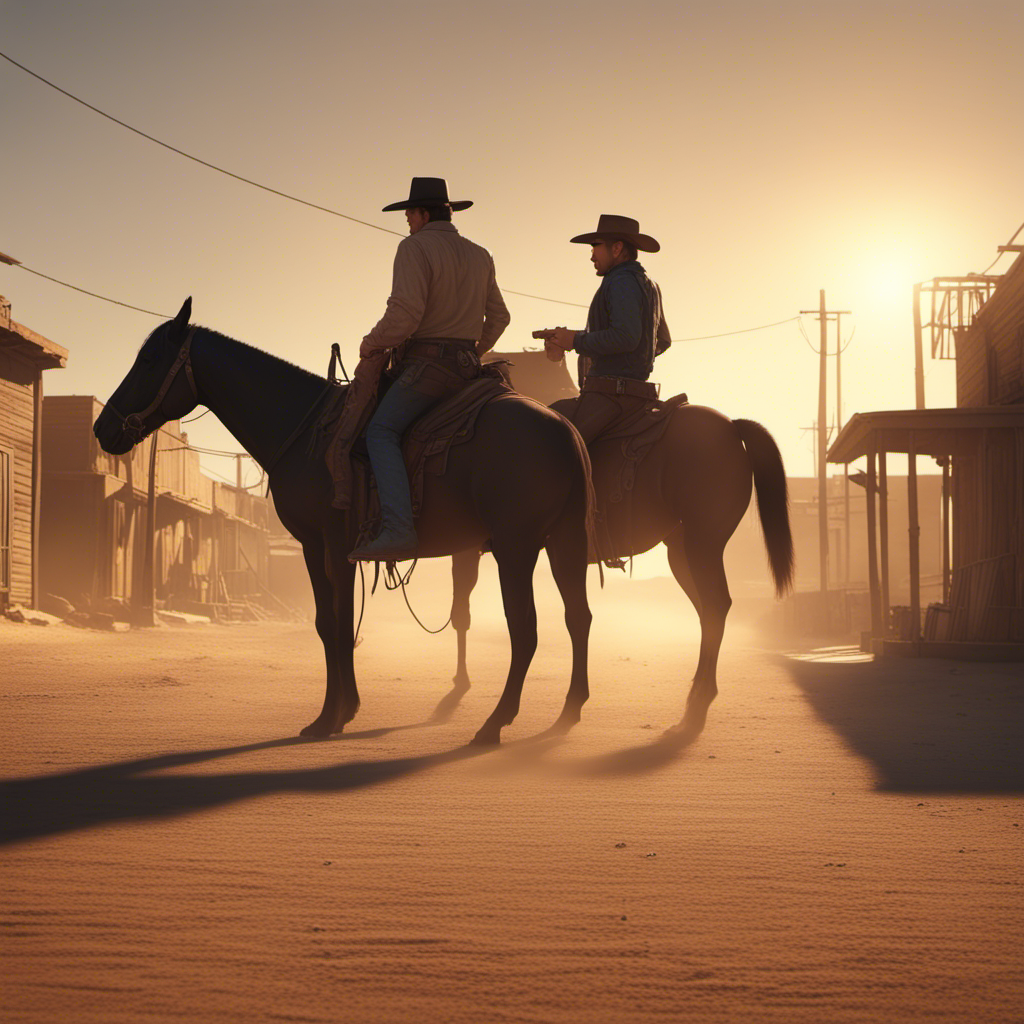

Done! Move to the next cell ->


In [27]:
# test the endpoint
import random

# get the model we deployed from parameter store
response = ssm.get_parameter(
    Name=myParameterStoreChosenModel
)
chosenModel = response['Parameter']['Value']
modelType = chosenModel.split("|")[0]
modelID = chosenModel.split("|")[1]
instanceType = chosenModel.split("|")[2].split(" ")[0]
print(f"You selected: model type {modelType} {modelID} on {instanceType}")

if modelType == "llm":
    example_payloads = [
        {
            "body": {
                "inputs": "Describe what a llm model can do for someone who is sceptical about them",
                "parameters": {
                    "max_new_tokens": 128,
                    "temperature": 0.2,
                    "top_p": 0.9,
                },
            },
            "content_type": "application/json",
            "accept": "application/json",
        },
    ]
else:
    example_payloads = [
        {
            "text_prompts": [
                {
                    "text": "A cowboy standoff at sunset in a dusty desert town, cinematic wide shot, golden hour lighting, photorealistic"
                }
            ],
            "width": 1024,
            "height": 1024,
            "cfg_scale": 7.0,
            "steps": 150,
            "seed": random.randint(0, 4294967295),
        },
    ]

for payload in example_payloads:
    if modelType == "llm":
        body = payload.body if hasattr(payload, "body") else payload["body"]
        response = predictor.predict(body)
        response = response[0] if isinstance(response, list) else response
        print("Input:\n", body, end="\n\n")
        print("Output:\n", response["generated_text"].strip(), end="\n\n\n")
    else:
        #payload = json.dumps(payload).encode("utf-8") # in case you change the image model that needs it
        response = predictor.predict(payload)
        decode_and_show(response["generated_image"])

print("Done! Move to the next cell ->")

# <span style="color:DarkSeaGreen">Create Scalability Plan</span>
- Uses SageMaker Application Auto Scaling
- Works especially well for generative AI models, which are typically concurrency-bound and can take many seconds to complete each inference request
- Using the new high-resolution metrics allow you to greatly decrease the time it takes to scale up an endpoint using Application Auto Scaling

In [9]:
# https://github.com/aws/amazon-sagemaker-examples/blob/main/inference/generativeai/huggingfacetgi/meta-llama/llama3-8b/faster-autoscaling/realtime-endpoints/FasterAutoscaling-SME-Llama3-8B-AppAutoScaling.ipynb
# https://aws.amazon.com/blogs/machine-learning/amazon-sagemaker-inference-launches-faster-auto-scaling-for-generative-ai-models/
# https://docs.aws.amazon.com/autoscaling/application/userguide/what-is-application-auto-scaling.html

# define a new auto scaling target for Application Auto Scaling
# we will use target tracking scaling - scale a resource based on a target value for a specific CloudWatch metric
# auto scaling
autoScaling = boto3.client('application-autoscaling', region_name=myRegion, verify=where())
variantName = "AllTraffic"
ResourceId  = "endpoint/" + endpointName + "/variant/" + variantName

# Register scalable target
scalableTarget = autoScaling.register_scalable_target(
    ServiceNamespace="sagemaker",
    ResourceId=ResourceId,
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",
    MinCapacity=1,
    MaxCapacity=3,  # Replace with your desired maximum instances
)

print ('Done! Move to the next cell ->')

Done! Move to the next cell ->


In [10]:
# create target tracking scaling policy
# this is a target tracking policy that uses the new high-resolution metrics for SageMaker endpoints
# you can also create a step-scaling policy if you prefer
# a step-scaling policy is more complex to set up, but gives you more control over how your endpoint scales

# create a policy that scales out when the endpoint receives more than n ConcurrentRequestsPerModel
# this new metric will be tracked when th predefined metric type used below is SageMakerVariantConcurrentRequestsPerModelHighResolution
# https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/application-autoscaling/client/put_scaling_policy.html
# NOTE this creates alarms with default thresholds, you can modify these alarms after creation if you want to change the thresholds
# Eg 90 datapoints within 15 minutes" is the default conservative behavior for scale-in to prevent flapping
# you can change this to a more aggressive scale-in policy if you want to scale in faster by modifying the alarm created though not recommended
# AWS automatically sets the scale-out and scale-in thresholds based on the TargetValue you specify in your target tracking policy
# these thresholds determine when your endpoint variant scales up or down
# sageMaker automatically populates the metric data for your endpoint, so no manual configuration is needed.
# https://docs.aws.amazon.com/sagemaker/latest/dg/endpoint-auto-scaling-add-code-define.html#endpoint-auto-scaling-add-code-high-res
targetTrackingPolicyResponse = autoScaling.put_scaling_policy(
    PolicyName=myEndpointScalingPolicyName,
    ServiceNamespace="sagemaker",
    ResourceId=ResourceId,
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",
    PolicyType="TargetTrackingScaling",
    TargetTrackingScalingPolicyConfiguration={
        "TargetValue": 5.0,  # Scaling triggers when endpoint receives 5 ConcurrentRequestsPerModel
        "PredefinedMetricSpecification": {
            "PredefinedMetricType": "SageMakerVariantConcurrentRequestsPerModelHighResolution"
        },
        "ScaleInCooldown": 180,  # Cooldown period after scale-in activity
        "ScaleOutCooldown": 180,  # Cooldown period after scale-out activity
    },
)

# print(target_tracking_policy_response)
print(f"[b]Policy ARN:[/b] [i blue]{targetTrackingPolicyResponse['PolicyARN']}")

# print Cloudwatch Alarms
alarms = targetTrackingPolicyResponse["Alarms"]

for alarm in alarms:
    print(f"[b]Alarm Name:[/b] [b magenta]{alarm['AlarmName']}")
    # print(f"[b]Alarm ARN:[/b] [i green]{alarm['AlarmARN']}[/i green]")
    print("===" * 15)

print ('Done! Move to the next cell ->')

[b]Policy ARN:[/b] [i blue]arn:aws:autoscaling:us-east-1:546709318047:scalingPolicy:f5f98ae6-af4b-4533-9df3-49383fe0583b:resource/sagemaker/endpoint/stabilityai-stable-diffusion-xl-base-1--2025-09-26-07-12-04-199/variant/AllTraffic:policyName/doit-jumpstart-sagemaker-endpoint-scaling-policy
[b]Alarm Name:[/b] [b magenta]TargetTracking-endpoint/stabilityai-stable-diffusion-xl-base-1--2025-09-26-07-12-04-199/variant/AllTraffic-AlarmHigh-87fc758c-34bf-4ab6-86b1-9939b6cf2a1c
[b]Alarm Name:[/b] [b magenta]TargetTracking-endpoint/stabilityai-stable-diffusion-xl-base-1--2025-09-26-07-12-04-199/variant/AllTraffic-AlarmLow-4ad5dcf9-f7e9-4dc8-a86e-5f77e6c75c1e
Done! Move to the next cell ->


# <span style="color:DarkSeaGreen">Test Scalability Plan</span>
- Lets just test the endpoint first, make sure its all good
- Simulate load

In [21]:
# now we're going to use locust to simulate load on the endpoint
# https://docs.locust.io/en/stable/ 
# https://aws.amazon.com/blogs/machine-learning/best-practices-for-load-testing-amazon-sagemaker-real-time-inference-endpoints/
# see the locust_script_lab2.py file for details of the load test
# it gathers the endpoint name, etc via os environment vars we export below
# run this cell, then paste and run in a terminal window, make sure its run in your virtual environment created in lab 1, or in your own that has boto3 and locust installed

print ("export AWS_REGION={}".format(myRegion))
print ("export ENDPOINT_NAME={}".format(endpointName))
print ("export CONTENT_TYPE={}".format("application/json"))
print ("export MODEL_TYPE={}".format(modelType))
print ("export HOST={}".format('http://localhost'))
if modelType == "llm":
    print ("export PAYLOAD='{}'".format('{"inputs": "Please explain what load testing is and why its important in reference to sagemaker endpoints"}'))
else:
    print ("export PAYLOAD='{}'".format('A cowboy standoff at sunset in a dusty desert town, cinematic wide shot, golden hour lighting, photorealistic'))


export AWS_REGION=us-east-1
export ENDPOINT_NAME=stabilityai-stable-diffusion-xl-base-1--2025-09-26-07-12-04-199
export CONTENT_TYPE=application/json
export MODEL_TYPE=txt2img
export HOST=http://localhost
export PAYLOAD='A cowboy standoff at sunset in a dusty desert town, cinematic wide shot, golden hour lighting, photorealistic'


In [ ]:
# these are picked up by the locust file
# Paste the following in a terminal window, make sure its run in your virtual environment created in lab 1, or in your own that has boto3 and locust installed
# LOCUST_USERS is the number of simulated users
# LOCUST_SPAWN_RATE is the rate per second to spawn (add new) users - so 20 users at rate of 2 means add 2 users every second, so take 10 seconds to get to 20 users
# LOCUST_RUN_TIME is how long to run the test for
export LOCUST_USERS=20
export LOCUST_SPAWN_RATE=0.5
export LOCUST_RUN_TIME=10m

In [79]:
# DELETE ME CELL USED FOR TESTING
from PIL import Image
import base64
from io import BytesIO
from botocore.config import Config
import json

config = Config(
    region_name=myRegion,
    retries={"max_attempts": 1, "mode": "standard"},
    read_timeout=120,  # 2 minute
    connect_timeout=120
)
sagemaker_client = boto3.client("sagemaker-runtime", config=config)

payload_dict = {
    "text_prompts": [{"text": "A cowboy standoff at sunset in a dusty desert town, cinematic wide shot, golden hour lighting, photorealistic", "weight": 1}],
    "width": 512,
    "height": 512,
    "cfg_scale": 7.0,
    "steps": 30,
    "seed": random.randint(0, 4294967295),
}
payload2 = json.dumps(payload_dict).encode("utf-8")

response = sagemaker_client.invoke_endpoint(
    EndpointName=endpointName,
    Body=payload2,
    ContentType='application/json',
)
raw_body = response.get("Body").read()
# Convert bytes -> string
body_str = raw_body.decode("utf-8")
# Parse JSON
result = json.loads(body_str)
# Get the base64 string
image_b64 = result["generated_image"].strip()  # remove extra whitespace/newlines

# Decode base64
image_bytes = base64.b64decode(image_b64)

# Open and show the image
image = Image.open(BytesIO(image_bytes))
image.show()


In [77]:
result

{'generated_image': 'iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAIAAAB7GkOtAAEAAElEQVR4nGz9O7Nty5U1CrWWc6599KhSSSodnSNVffwZIq6DgQFxI8AAhwgwCCy8G0SABw4OgYWHh4mFh3V/Cfcr6ejoVaV6SGevObJhtNZ6jqXvbklbe6895xiZPfuj9Wfyv/mf/g8BQAt4aT+wLulBvGu/ab1Lb+RLeoIv6Am8MH/mC3puvIin/PN17f1YvPx56Um+tB/gJTzIl3Z+jv4Z+fMb1kv7AbxLD/Dae2G94O/qCb5rv/nz5At6E17QA3xhv4mfpTfgHXgTPkNv4gv7CV7SI2tY194Prpf2Q7f1a912hBdwW5We5Gtvv/GJ88wn8A69bXwGPoHv2k8s7+gdehPfkb335+td+8l1YT+wXthv/qSfc1tPvgu8Q5/gP/Ml9fNnbQ/y0n4qdAs1hDevVvc1rxf05PL636W3j6fwrrz37baXN4YyF/QAL+jJdcnP0f0sbuvJJx/g5bPLGfXzMt34DjyJV05Hb8jaLuqBdZXO6+NZXNKD69L2u57gRYQOWKbAJT3/mkr5yQPcOCvc0CKv7BHZ46xZt59Lb1kbL2jlOV0JtIDuHaFDqIELemDlXbMSlkrSA9zmz3kOeQlPcktrLUHs2jbxuJ8I7jTHBZzfpUVuUwz3c1Hk0bsQL2ARW1peg9/LtbX9mefiPrvGBSzpBTwsL8IFPIgNLPS7eReewEUsYOfJee8CN0Bg387CP79T7+XdWYegz/EpR5q48f41eOHxB3ADq/TPesKHeNDUw5Wfa5GSaCplX7jrgUtaXIIWsIGHeBGLUGh7e86sPBxienJOgaSU5yxw07Taa63dtxwaltpLOPwmXtRD/q42sGRqM++ab6HrwQeOfQIX+fDv0kU+tV9P8EFcGwS5AUBYFCgS54eE/woCACkC+TmEJRD+0eImsOEfCMDyZygQiyIhCsRjAYS

# <span style="color:DarkSeaGreen">Before Locust is Run</span>
- Go to the CloudWatch console
- Monitor the alarm being target tracked for ConcurrentRequestsPerModel, eg 
  - TargetTracking-endpoint/*endpoint name*-Alarm**High**-*uuid*
  - TargetTracking-endpoint/*endpoint name*-Alarm**Low**-*uuid*
- Run the cell below to monitor the instance count



In [18]:
import time
from datetime import datetime, timedelta

# --- Configuration ---
endpoint_name = endpointName
region = myRegion
poll_interval = 10    # seconds between checks

# --- Clients ---
sm_client = boto3.client("sagemaker", region_name=region)
cw_client = boto3.client("cloudwatch", region_name=region)

print(f"Monitoring endpoint '{endpoint_name}' variants (press Ctrl+C to stop)...\n")
print("Alarms for reference:")
print(f"High Scaling In Alarm: {alarms[1]['AlarmName']} | Scale in cooldown (seconds): {cw_client.describe_alarms(AlarmNames=[alarms[0]['AlarmName']])['MetricAlarms'][0]['Period'] * cw_client.describe_alarms(AlarmNames=[alarms[0]['AlarmName']])['MetricAlarms'][0]['EvaluationPeriods']} | when below {cw_client.describe_alarms(AlarmNames=[alarms[0]['AlarmName']])['MetricAlarms'][0]['Threshold']} for {cw_client.describe_alarms(AlarmNames=[alarms[0]['AlarmName']])['MetricAlarms'][0]['EvaluationPeriods']} periods of {cw_client.describe_alarms(AlarmNames=[alarms[0]['AlarmName']])['MetricAlarms'][0]['Period']} seconds")
print(f"Low Scaling In Alarm: {alarms[1]['AlarmName']} | Scale in cooldown (seconds): {cw_client.describe_alarms(AlarmNames=[alarms[1]['AlarmName']])['MetricAlarms'][0]['Period'] * cw_client.describe_alarms(AlarmNames=[alarms[1]['AlarmName']])['MetricAlarms'][0]['EvaluationPeriods']} | when below {cw_client.describe_alarms(AlarmNames=[alarms[1]['AlarmName']])['MetricAlarms'][0]['Threshold']} for {cw_client.describe_alarms(AlarmNames=[alarms[1]['AlarmName']])['MetricAlarms'][0]['EvaluationPeriods']} periods of {cw_client.describe_alarms(AlarmNames=[alarms[1]['AlarmName']])['MetricAlarms'][0]['Period']} seconds")

try:
    while True:
        # --- Describe endpoint variants ---
        response = sm_client.describe_endpoint(EndpointName=endpoint_name)
        for variant in response["ProductionVariants"]:
            variant_name = variant["VariantName"]
            current_instances = variant["CurrentInstanceCount"]
            desired_instances = variant["DesiredInstanceCount"]

            # --- Fetch latest ConcurrentRequestsPerModel metric ---
            end_time = datetime.utcnow()
            start_time = end_time - timedelta(seconds=poll_interval*2)  # small window to get the latest datapoint

            # get the ConcurrentRequestsPerModel metric for this variant
            metric_resp = cw_client.get_metric_statistics(
                Namespace="AWS/SageMaker",
                MetricName="ConcurrentRequestsPerModel",
                Dimensions=[
                    {"Name": "EndpointName", "Value": endpoint_name},
                    {"Name": "VariantName", "Value": variant_name},
                ],
                StartTime=start_time,
                EndTime=end_time,
                Period=poll_interval,
                Statistics=["Average"],
            )

            datapoints = metric_resp.get("Datapoints", [])
            concurrent_requests = round(datapoints[-1]["Average"], 2) if datapoints else 0

            print(
                f"[{time.strftime('%H:%M:%S')}] Variant: {variant_name} | "
                f"Current instances: {current_instances} | Desired instances: {desired_instances} | "
                f"ConcurrentRequestsPerModel: {concurrent_requests} | "
                f"High Scaling Out Alarm State: {cw_client.describe_alarms(AlarmNames=[alarms[0]['AlarmName']])['MetricAlarms'][0]['StateValue']} | "
                f"Low Scaling In Alarm State: {cw_client.describe_alarms(AlarmNames=[alarms[1]['AlarmName']])['MetricAlarms'][0]['StateValue']}"
            )

        print("-" * 80)
        time.sleep(poll_interval)

except KeyboardInterrupt:
    print(f"Monitoring stopped.")
    # print each alarm name and description on a new line
    print("Alarms for reference:")
    print(f"High Scaling In Alarm: {alarms[1]['AlarmName']} | Scale in cooldown (seconds): {cw_client.describe_alarms(AlarmNames=[alarms[0]['AlarmName']])['MetricAlarms'][0]['Period'] * cw_client.describe_alarms(AlarmNames=[alarms[0]['AlarmName']])['MetricAlarms'][0]['EvaluationPeriods']} | when below {cw_client.describe_alarms(AlarmNames=[alarms[0]['AlarmName']])['MetricAlarms'][0]['Threshold']} for {cw_client.describe_alarms(AlarmNames=[alarms[0]['AlarmName']])['MetricAlarms'][0]['EvaluationPeriods']} periods of {cw_client.describe_alarms(AlarmNames=[alarms[0]['AlarmName']])['MetricAlarms'][0]['Period']} seconds")
    print(f"Low Scaling In Alarm: {alarms[1]['AlarmName']} | Scale in cooldown (seconds): {cw_client.describe_alarms(AlarmNames=[alarms[1]['AlarmName']])['MetricAlarms'][0]['Period'] * cw_client.describe_alarms(AlarmNames=[alarms[1]['AlarmName']])['MetricAlarms'][0]['EvaluationPeriods']} | when below {cw_client.describe_alarms(AlarmNames=[alarms[1]['AlarmName']])['MetricAlarms'][0]['Threshold']} for {cw_client.describe_alarms(AlarmNames=[alarms[1]['AlarmName']])['MetricAlarms'][0]['EvaluationPeriods']} periods of {cw_client.describe_alarms(AlarmNames=[alarms[1]['AlarmName']])['MetricAlarms'][0]['Period']} seconds")


Monitoring endpoint 'stabilityai-stable-diffusion-xl-base-1--2025-09-26-07-12-04-199' variants (press Ctrl+C to stop)...

Alarms for reference:
High Scaling In Alarm: TargetTracking-endpoint/stabilityai-stable-diffusion-xl-base-1--2025-09-26-07-12-04-199/variant/AllTraffic-AlarmLow-4ad5dcf9-f7e9-4dc8-a86e-5f77e6c75c1e | Scale in cooldown (seconds): 30 | when below 5.0 for 3 periods of 10 seconds
Low Scaling In Alarm: TargetTracking-endpoint/stabilityai-stable-diffusion-xl-base-1--2025-09-26-07-12-04-199/variant/AllTraffic-AlarmLow-4ad5dcf9-f7e9-4dc8-a86e-5f77e6c75c1e | Scale in cooldown (seconds): 900 | when below 4.5 for 90 periods of 10 seconds


/var/folders/_s/nlp433gs2q54y8h1j_pp0p240000gn/T/ipykernel_70872/380409141.py:28: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_time = datetime.utcnow()


[16:06:49] Variant: AllTraffic | Current instances: 2 | Desired instances: 2 | ConcurrentRequestsPerModel: 0.0 | High Scaling Out Alarm State: OK | Low Scaling In Alarm State: ALARM
--------------------------------------------------------------------------------
[16:07:01] Variant: AllTraffic | Current instances: 2 | Desired instances: 2 | ConcurrentRequestsPerModel: 0.0 | High Scaling Out Alarm State: OK | Low Scaling In Alarm State: ALARM
--------------------------------------------------------------------------------
[16:07:15] Variant: AllTraffic | Current instances: 2 | Desired instances: 2 | ConcurrentRequestsPerModel: 0.0 | High Scaling Out Alarm State: OK | Low Scaling In Alarm State: ALARM
--------------------------------------------------------------------------------
[16:07:27] Variant: AllTraffic | Current instances: 2 | Desired instances: 2 | ConcurrentRequestsPerModel: 0.0 | High Scaling Out Alarm State: OK | Low Scaling In Alarm State: ALARM
-----------------------------

# <span style="color:DarkSeaGreen">Start Locust</span>
- Paste the command into your terminal window in your venv

In [ ]:
# now we're going to use locust to simulate load on the endpoint
# https://docs.locust.io/en/stable/ 
# https://aws.amazon.com/blogs/machine-learning/best-practices-for-load-testing-amazon-sagemaker-real-time-inference-endpoints/
# see the locust_script_lab2.py file for details of the load test
# it gathers the endpoint name, etc from the parameter store where we stored it in lab 1

# Paste the following in a terminal window, make sure its run in your virtual environment created in lab 1, or in your own that has boto3 and locust installed
# this will run in headless mode, use the properties just exported, and write csv logs for use in graph cells below
locust -f locust_script_lab2.py --headless -u $LOCUST_USERS -r $LOCUST_SPAWN_RATE --run-time $LOCUST_RUN_TIME --host http://localhost --csv results --csv-full-history

# for quick testing you can run with just 1 user, spawning at rate of 1 user per second, for 2 minutes
locust -f locust_script_lab2.py --headless -u 1 -r 1 --run-time 2m --host http://localhost --csv results --csv-full-history

# OR
# if you want to see the locust web UI, then run without --headless and point your browser at http://localhost:8089
# it will still write the csv files for use in graph cells below
locust -f locust_script_lab2.py -u $LOCUST_USERS -r $LOCUST_SPAWN_RATE --run-time $LOCUST_RUN_TIME --host http://localhost --csv results --csv-full-history

# <span style="color:DarkSeaGreen">Review Stats</span>
- After Locust has finished, we can review the stats it wrote as csv files
- NOTE the endpoint will not scale back in for 15 minutes (value may change depending on the scaling policy) after locust has finished its run - see above for a description of this
  - therefore when viewing the charts below, it will not reflect a scale in event for 15 minutes 

#### SageMaker Endpoint Latency Under Load
  - See how your SageMaker endpoint responds as load increases, and correlate that with autoscaling events
  - NOTE this uses the results csv file written by locust, so wait until locust finishes before running this and subsequent cells

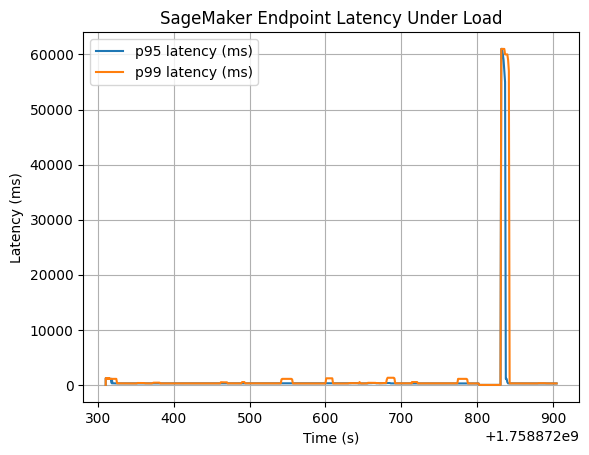

In [13]:
# Plot response times over time
import pandas as pd
import matplotlib.pyplot as plt

# Load the full history file
df = pd.read_csv("results_stats_history.csv")
df.head()

# Plot response times over time
plt.plot(df["Timestamp"], df["95%"], label="p95 latency (ms)")
plt.plot(df["Timestamp"], df["99%"], label="p99 latency (ms)")
plt.xlabel("Time (s)")
plt.ylabel("Latency (ms)")
plt.title("SageMaker Endpoint Latency Under Load")
plt.legend()
plt.grid(True)
plt.show()

#### Concurrent Users vs. Request Rate
- Total RPS (Requests per second) → how busy your endpoint is at each interval
- Concurrent Users → how many simulated users are active at that moment
- Compare these to your endpoint instance count and scaling policy in SageMaker to see if the scaling is working as expected

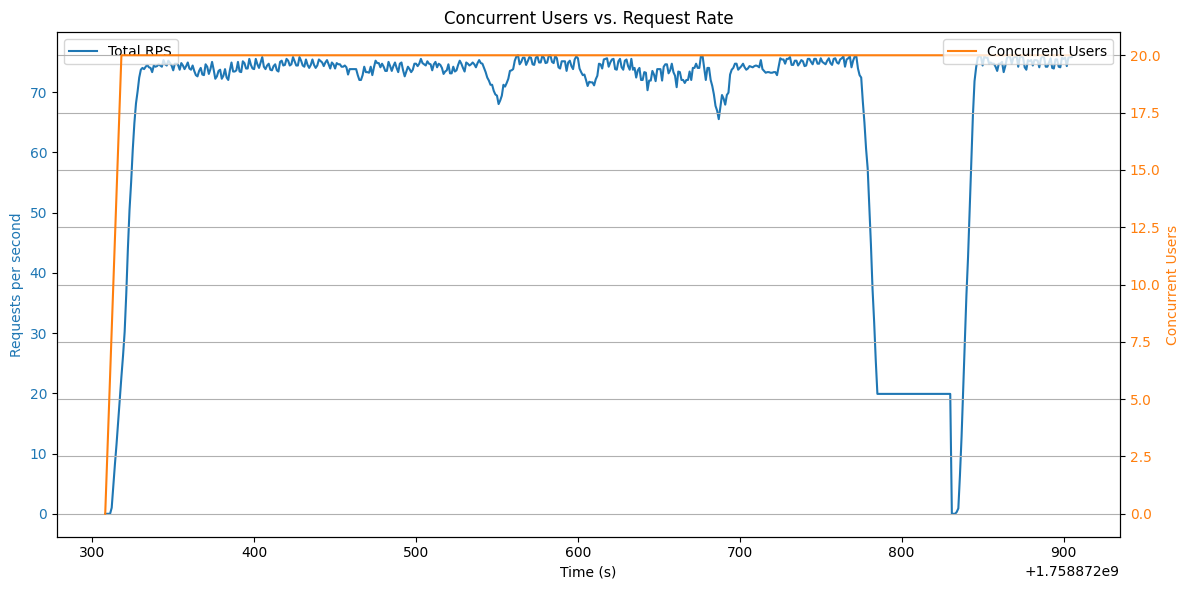

In [14]:
# Plot Concurrent Users and Requests per Second
fig, ax1 = plt.subplots(figsize=(12,6))

# Left Y-axis: Requests per second
ax1.plot(df["Timestamp"], df["Requests/s"], color="tab:blue", label="Total RPS")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Requests per second", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Right Y-axis: Number of concurrent users
ax2 = ax1.twinx()
ax2.plot(df["Timestamp"], df["User Count"], color="tab:orange", label="Concurrent Users")
ax2.set_ylabel("Concurrent Users", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

# Titles & Legends
plt.title("Concurrent Users vs. Request Rate")
fig.tight_layout()
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.grid(True)
plt.show()


#### Concurrent Requests vs. Instance Count
- Show when the instance scales
- Pulls SageMaker endpoint metrics from CloudWatch
- Handles empty or missing data gracefully
- Converts them into a DataFrame for analysis
- Plots the metric values over time
- If the instance has not scaled in yet, its probably still within the 15 minutes (may be different depending on policy) of the scale in threshold, check the alarm in the console for details
- NOTE there is a lookback in minutes defined below, so the cell output is only relevant if its run shortly after locust has finished, any longer and it may not get results from the metrics

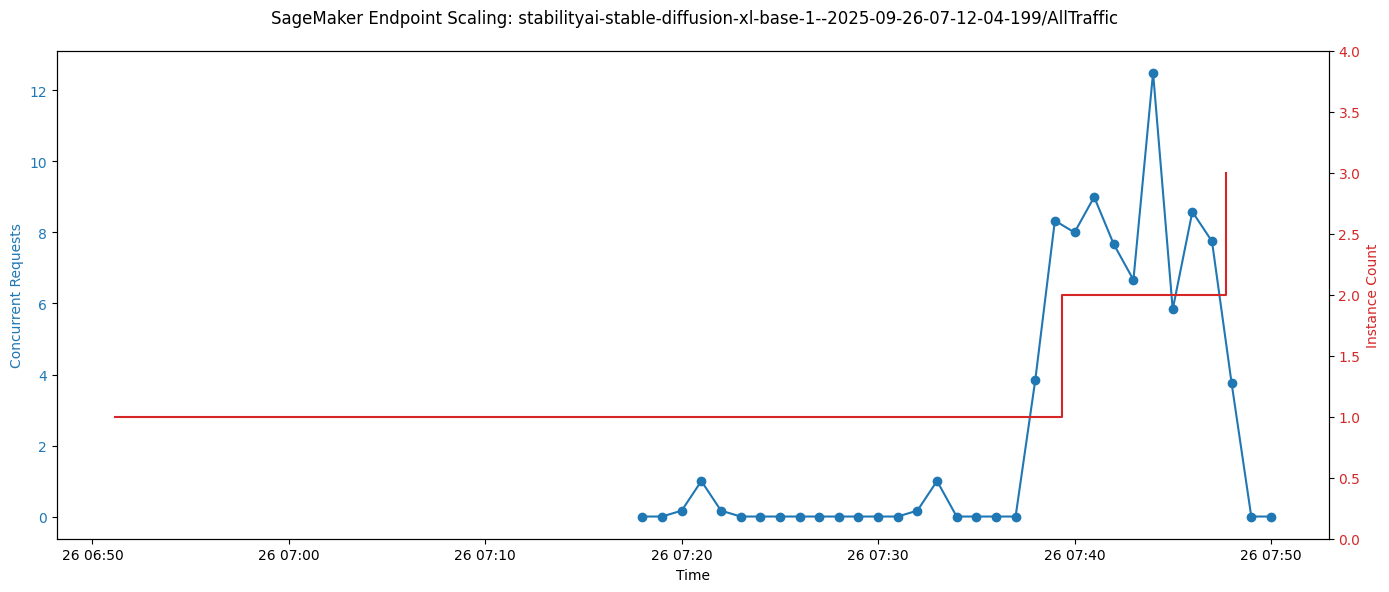

,Timestamp,Average,Unit
22,2025-09-26 07:18:00+00:00,0.000000,Count
16,2025-09-26 07:19:00+00:00,0.000000,Count
18,2025-09-26 07:20:00+00:00,0.166667,Count
20,2025-09-26 07:21:00+00:00,1.000000,Count
30,2025-09-26 07:22:00+00:00,0.166667,Count
32,2025-09-26 07:23:00+00:00,0.000000,Count
25,2025-09-26 07:24:00+00:00,0.000000,Count
27,2025-09-26 07:25:00+00:00,0.000000,Count
4,2025-09-26 07:26:00+00:00,0.000000,Count
6,2025-09-26 07:27:00+00:00,0.000000,Count


,Timestamp,NewCapacity,StatusCode,StatusMessage
0,2025-09-26 14:51:07.880215+08:00,1.0,Simulated,NaN
2,2025-09-26 15:39:21.331000+08:00,2.0,Successful,Successfully set desired instance count to 2. ...
1,2025-09-26 15:47:41.282000+08:00,3.0,InProgress,Successfully set desired instance count to 3. ...


,Timestamp,NewCapacity,StatusCode,ActivityId,ServiceNamespace,ResourceId,ScalableDimension,Description,Cause,StartTime,StatusMessage,EndTime
0,2025-09-26 14:51:07.880215+08:00,1.0,Simulated,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT
2,2025-09-26 15:39:21.331000+08:00,2.0,Successful,139e7d52-c3b3-40db-8f6e-7226383a1050,sagemaker,endpoint/stabilityai-stable-diffusion-xl-base-...,sagemaker:variant:DesiredInstanceCount,Setting desired instance count to 2.,monitor alarm TargetTracking-endpoint/stabilit...,2025-09-26 15:39:21.331000+08:00,Successfully set desired instance count to 2. ...,2025-09-26 15:46:29.206000+08:00
1,2025-09-26 15:47:41.282000+08:00,3.0,InProgress,db8dcd63-db07-45a9-86e3-d2f5c499342c,sagemaker,endpoint/stabilityai-stable-diffusion-xl-base-...,sagemaker:variant:DesiredInstanceCount,Setting desired instance count to 3.,monitor alarm TargetTracking-endpoint/stabilit...,2025-09-26 15:47:41.282000+08:00,Successfully set desired instance count to 3. ...,NaT


In [15]:
from datetime import datetime, timedelta, timezone

lookback_minutes = 60  # how far back to fetch metrics

cw = boto3.client("cloudwatch", region_name=region)
aas = boto3.client("application-autoscaling", region_name=region)

end_time = datetime.now(timezone.utc)
start_time = end_time - timedelta(minutes=lookback_minutes)

# --- 1. Get CloudWatch metric: ConcurrentRequestsPerModel ---
metrics = cw.get_metric_statistics(
    Namespace="AWS/SageMaker",
    MetricName="ConcurrentRequestsPerModel",
    Dimensions=[{"Name": "EndpointName", "Value": endpoint_name},
                {"Name": "VariantName", "Value": variant_name}],
    StartTime=start_time,
    EndTime=end_time,
    Period=60,
    Statistics=["Average"],
)

datapoints = metrics.get("Datapoints", [])
cw_df = pd.DataFrame(datapoints)

if cw_df.empty:
    print("⚠️ No CloudWatch datapoints found for ConcurrentRequestsPerModel")
else:
    cw_df["Timestamp"] = pd.to_datetime(cw_df["Timestamp"])
    cw_df.sort_values("Timestamp", inplace=True)

# --- 2. Get Current & Desired Instance Counts ---
scalable_target = aas.describe_scalable_targets(
    ServiceNamespace="sagemaker",
    ResourceIds=[f"endpoint/{endpoint_name}/variant/{variant_name}"],
    ScalableDimension="sagemaker:variant:DesiredInstanceCount"
)
desired_min = scalable_target["ScalableTargets"][0]["MinCapacity"]
desired_max = scalable_target["ScalableTargets"][0]["MaxCapacity"]

# --- 3. Get actual scaling activity history (DesiredInstanceCount changes) ---
scaling_history = aas.describe_scaling_activities(
    ServiceNamespace="sagemaker",
    ResourceId=f"endpoint/{endpoint_name}/variant/{variant_name}",
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",
    MaxResults=20
)

scaling_df = pd.DataFrame(scaling_history.get("ScalingActivities", []))

if not scaling_df.empty:
    scaling_df["Timestamp"] = pd.to_datetime(scaling_df["StartTime"])
    # Check if timestamps are timezone-aware
    tzinfo = scaling_df["Timestamp"].dt.tz  # will be None if naive
    lookback_start = datetime.now(tz=tzinfo) - timedelta(minutes=lookback_minutes)

    # Define cutoff
    cutoff_time = datetime.now(timezone.utc) - timedelta(minutes=lookback_minutes)
    # Restrict to only rows newer than cutoff
    scaling_df = scaling_df[scaling_df["Timestamp"] >= cutoff_time].copy()
    # extract the instance count
    scaling_df["NewCapacity"] = scaling_df["Description"].str.extract(r"(\d+)(?=\D*$)").astype(float)
    # Insert synthetic row at lookback start
    synthetic_row = pd.DataFrame({
        "Timestamp": [lookback_start],
        "NewCapacity": [1.0],  # default instance count
        "StatusCode": ["Simulated"],
    })
    scaling_df = pd.concat([synthetic_row, scaling_df], ignore_index=True)

    # Sort for plotting
    scaling_df.sort_values("Timestamp", inplace=True)

# --- 4. Plot everything together ---
if not cw_df.empty:
    fig, ax1 = plt.subplots(figsize=(14, 6))

    # Plot concurrency (left axis)
    ax1.plot(cw_df["Timestamp"], cw_df["Average"], marker="o", color="tab:blue", label="ConcurrentRequestsPerModel")
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Concurrent Requests", color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    # Plot desired instance count (right axis)
    ax2 = ax1.twinx()
    if not scaling_df.empty:
        ax2.step(scaling_df["Timestamp"], scaling_df["NewCapacity"], where="post", color="tab:red", label="DesiredInstanceCount")
    ax2.set_ylabel("Instance Count", color="tab:red")
    ax2.tick_params(axis="y", labelcolor="tab:red")
    ax2.set_ylim(0, desired_max + 1)

    fig.suptitle(f"SageMaker Endpoint Scaling: {endpoint_name}/{variant_name}")
    fig.tight_layout()
    plt.show()

    display(cw_df.head(10))
    if not scaling_df.empty:
        display(scaling_df[["Timestamp", "NewCapacity", "StatusCode", "StatusMessage"]].head(10))
        display(scaling_df)



# <span style="color:DarkSeaGreen">SageMaker Inference Recommender</span>
- Helps you select the best instance type and configuration for your ML models and workloads
- Suitable for traditional ML and deep learning models - **no documented usage for LLMs** - added here for reference only
- https://docs.aws.amazon.com/sagemaker/latest/dg/inference-recommender.html
- NOTE NEEDS TO BE INVESTIGATED TO SEE IF IT WORKS WITH LLM REAL TIME ENDPOINTS

# <span style="color:DarkSeaGreen">Clean Up Architecture</span>
### <span style="color:Red">Only do this if you have finished with this lab and any labs that depend on it!</span>
##### It will delete all architecture created, make sure you no longer need any of it!!!

In [ ]:
# when finished with the endpoint, delete it
# endpoint and all other architecture is deleted in lab 1
# nothing to do here